# Analysing public transport for 2017/18 using the BART Dataset

Importing the necessary libraries:

In [2]:
#!conda install holoviews

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
import holoviews as hv
from holoviews import opts, dim
from bokeh.plotting import show, output_file
import numpy as np

### Importing the dataset:

The 2017 and 2018 BART datasets are read using pandas and column names are added. The two dataframes are then concatenated together to form one dataset ranging over two years. The dataset contains the *date* column in format YYYY-MM-DD, *hour* column as a single integer, *org_station* column a four character origin station code, *dest_station* column a four character destination station code and the *trip_count* column the total number of trips. 

In [13]:
filenames = ['http://64.111.127.166/origin-destination/date-hour-soo-dest-2017.csv.gz', 'http://64.111.127.166/origin-destination/date-hour-soo-dest-2018.csv.gz']
list_of_dfs = [pd.read_csv(filename, names=['date', 'hour', 'org_station', 'dest_station', 'trip_count']) for filename in filenames]
df = pd.concat(list_of_dfs, ignore_index=True, sort=False)

In [14]:
df.head()

,date,hour,org_station,dest_station,trip_count
0,2017-01-01,0,12TH,19TH,1
1,2017-01-01,0,12TH,24TH,2
2,2017-01-01,0,12TH,BAYF,1
3,2017-01-01,0,12TH,CIVC,5
4,2017-01-01,0,12TH,COLS,2


Checking for any nulls in the integer columns:

In [4]:
print("number of NaN values for the column Hour :", df['hour'].isnull().sum())
print("number of NaN values for the column Trip_Count :", df['trip_count'].isnull().sum())

number of NaN values for the column Hour : 0
number of NaN values for the column Trip_Count : 0


Summary description of dataset:

In [5]:
df.describe(include='all')

,date,hour,org_station,dest_station,trip_count
count,20201726,2.020173e+07,20201726,20201726,2.020173e+07
unique,730,NaN,48,48,NaN
top,2018-06-29,NaN,POWL,POWL,NaN
freq,31910,NaN,645843,632468,NaN
mean,NaN,1.363566e+01,NaN,NaN,1.204692e+01
std,NaN,5.614764e+00,NaN,NaN,3.231068e+01
min,NaN,0.000000e+00,NaN,NaN,1.000000e+00
25%,NaN,9.000000e+00,NaN,NaN,1.000000e+00
50%,NaN,1.400000e+01,NaN,NaN,3.000000e+00
75%,NaN,1.800000e+01,NaN,NaN,9.000000e+00


###  Plotting the average daily (from 0 to 24h) rideship pattern, averaging all O-D pairs:

To create the data for the chart, first a dataframe is created containing the mean average trips grouped by the *date* column and then sorted and indexed by *date* in ascending order.

In [15]:
df_group_date = df[['date','trip_count']]
df_avg_daily = df_group_date.groupby(['date'],as_index=False).mean()
df_avg_daily.rename(columns = {'trip_count':'avg_trips'}, inplace=True)
df_avg_daily = df_avg_daily.sort_values('date', ascending = True)
df_avg_daily.set_index('date', inplace=True)
df_avg_daily.head()

,avg_trips
date,
2017-01-01,5.955807
2017-01-02,6.014903
2017-01-03,13.295665
2017-01-04,13.987122
2017-01-05,14.324384


The data is then plotted and the chart is labelled. The chart shows the average trips per day with the x-axis showing the date in three month increments from 1<sup>st</sup> January 2017 to 31<sup>st</sup> December 2018 and the y-axis showing the average number of trips.

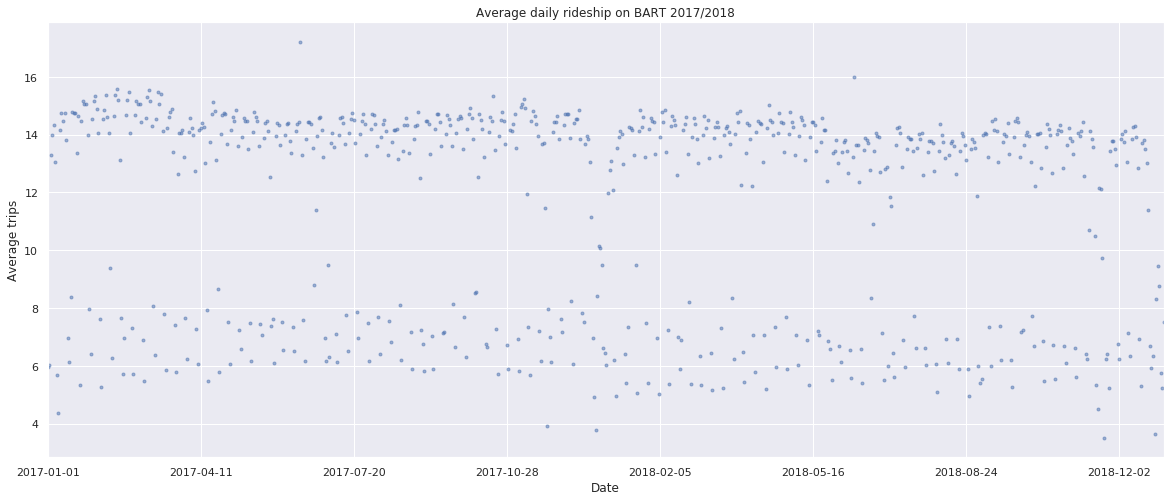

In [16]:
sns.set(rc={'figure.figsize':(20, 8)})
chart = df_avg_daily.plot(marker='.', alpha=0.5, linestyle = 'None')

chart.set_title('Average daily rideship on BART 2017/2018')
chart.set_ylabel('Average trips')
chart.set_xlabel('Date')
chart.get_legend().remove()

plt.show()

A scatter plot was chosen to best represent the data on the chart. With the large amount of data points a line chart proves harder to analyse. There is a clear separation that can be seen when the data is mapped as scatter points. The data has been split into two large clusters. The first cluster is denser with peaks of average trips in the range of 12-16 per day and the second cluster is sparser with the peaks in the range of 4-8 trips per day. There is no monthly or yearly seasonality trend, as it is quite consistent over the different months and years. However, there is a slight general decline in trips towards the end of each year.

An optimization to further the analysis and determine the root of the two clusters is to check if there is a daily seasonality trend based on the days of the week, which is shown below.

### Optimizing the average daily rideship chart:

To take the days of the week into account, a new column is added to the dataset to convert the *date* column into the weekday representation column *day*.

In [60]:
df_avg_daily_opt = df_avg_daily.reset_index()
df_avg_daily_opt['date'] = pd.to_datetime(df_avg_daily_opt.date)
df_avg_daily_opt['day'] = df_avg_daily_opt['date'].dt.day_name()
df_avg_daily_opt.head()

,date,avg_trips,day
0,2017-01-01,5.955807,Sunday
1,2017-01-02,6.014903,Monday
2,2017-01-03,13.295665,Tuesday
3,2017-01-04,13.987122,Wednesday
4,2017-01-05,14.324384,Thursday


The data is then plotted and the chart is labelled. The chart shows the average trips per day with the x-axis showing the date in three month increments from 1<sup>st</sup> January 2017 to 31<sup>st</sup> December 2018 and the y-axis showing the average number of trips. The individual days are color coded.

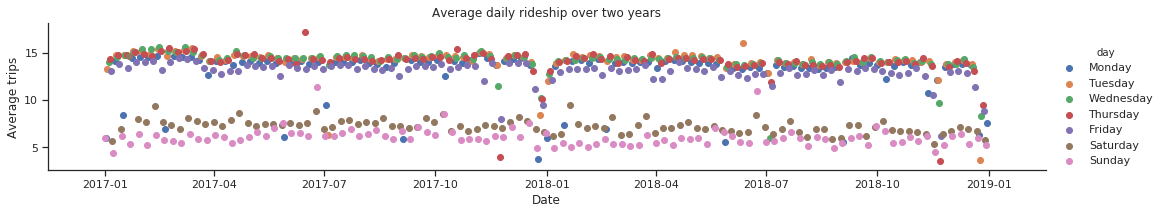

In [66]:
sns.set(style='ticks', rc={'figure.figsize':(20, 8)})

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
chart = sns.FacetGrid(data=df_avg_daily_opt, hue='day', hue_order=days, aspect=5)
chart.map(plt.scatter, 'date', 'avg_trips').add_legend()

plt.title('Average daily rideship over two years')
plt.xlabel('Date')
plt.ylabel('Average trips')
plt.show()

As can be seen from the optimised chart the daily seasonality can be clearly identified. The chart shows that weekdays (Monday through Friday) have higher average number of trips than weekends (Saturdays and Sundays) There are some outliers that can be seen such as a few points where weekdays have very few trips. One possible explaination for these could be that those dates lie on a public holiday.

###   Plotting the hourly rideship for 2 years (hour by hour for 2 years) for the 5 highest average rideship O-D pair:

To create the data for the chart, first we need to find the five highest average rideship O-D pairs. To do this two new columns in the dataset are created. The first called *station_pair* to hold a concatenation of the *org_station* and *dest_station* pairs for easier lookups. The second called *date_time* to hold a concatenation of the *date* and *hour* columns so a valid column of type datetime can be used as the x-axis of the chart.

A new dataframe is then created containing the mean average trips grouped by the *station_pair* column. The *station_pair* values for the five largest *avg_trips* are then added to a pandas.series called *top_five*.

In [13]:
df['station_pair'] = df['org_station'].map(str) + '_' + df['dest_station']
df['date_time'] = pd.to_datetime(df.date) + pd.to_timedelta(df.hour, unit='h')

In [14]:
df_group_five = df[['date_time','org_station','dest_station','station_pair','trip_count']]
df_top_five = df_group_five.groupby(['station_pair'],as_index=False).mean()
df_top_five.rename(columns= {'trip_count':'avg_trips'},inplace = True)
df_top_five = df_top_five.nlargest(5,'avg_trips', keep = 'all')

The five highest average rideship O-D pairs are:

In [15]:
top_five = df_top_five['station_pair']
print(top_five)

314     BALB_MONT
1686    POWL_BALB
785     DUBL_EMBR
170     24TH_MONT
323     BALB_POWL
Name: station_pair, dtype: object


A subset dataframe is created from the *top_five* pairs. Then the dataframe is transformed into a pivot table indexing and sorting on the *date_time* column with the *trip_count* as the values.

In [16]:
df_hourly_ride = df[df['station_pair'].isin(top_five)][['date_time','station_pair','trip_count']]
df_hourly_ride = df_hourly_ride.pivot_table(index = 'date_time', columns = 'station_pair', values= 'trip_count', fill_value=0)
df_hourly_ride = df_hourly_ride.sort_values('date_time', ascending = True)

In [17]:
df_hourly_ride.head()

station_pair,24TH_MONT,BALB_MONT,BALB_POWL,DUBL_EMBR,POWL_BALB
date_time,,,,,
2017-01-01 00:00:00,6,7,4,27,40
2017-01-01 01:00:00,8,0,7,4,126
2017-01-01 02:00:00,1,0,3,2,66
2017-01-01 03:00:00,0,0,0,0,7
2017-01-01 08:00:00,5,41,100,1,4


The data is then plotted and the chart is labelled. The chart shows the total trips per hour for the five highest average O-D pairs with the x-axis showing the hours in monthly increments from 1<sup>st</sup> January 2017 to 31<sup>st</sup> December 2018 and the y-axis showing the total number of trips.

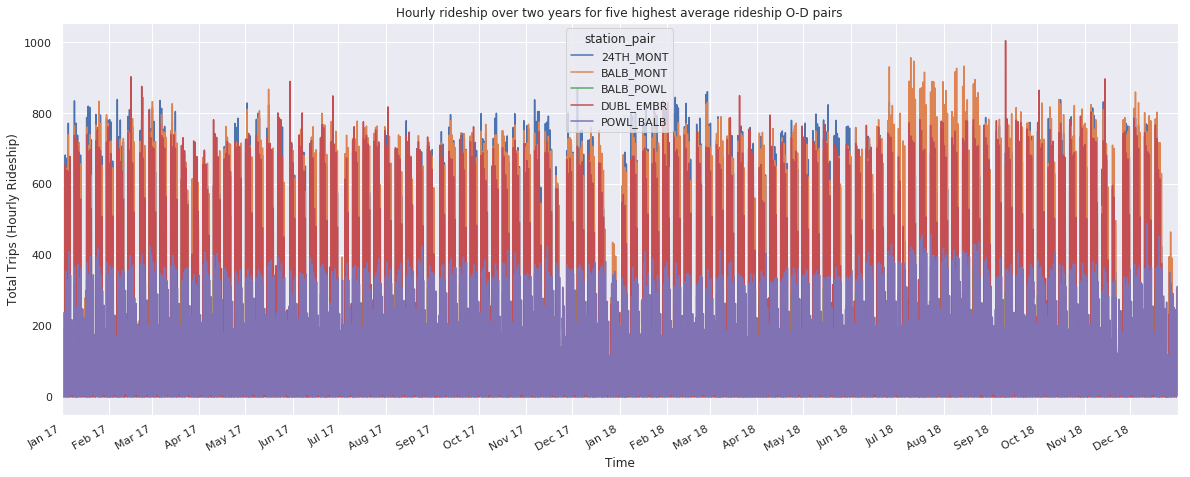

In [18]:
sns.set(rc={'figure.figsize':(20, 8)})

chart = df_hourly_ride.plot.line()
chart.set_ylabel("Total Trips (Hourly Rideship)")
chart.set_xlabel('Time')
chart.set_title('Hourly rideship over two years for five highest average rideship O-D pairs')
chart.xaxis.set_major_locator(mdates.MonthLocator())
chart.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.show()

Each of the five highest pairs are plotted on separate lines. The above chart excels in being able to find trends between the total usage of a given station pair e.g. The "POWL_BALB" route can be seen as having the lowest amount of total trips per hour compared to the other four station pairs. It is also a good indicator of seasonality with the "BALB_MONT" route's total trips being especially high in the months of July to September of 2018.

As you can see from the above chart it can be hard to find hourly trends from the chart as there is so much data being represented. A proposed optimization for this chart would be to find the total trips over the two years per hour, which can be seen below.

###  Optimizing the hourly rideship chart:

This chart has been plotted below by first creating a dataframe of the five highest station pairs as above and then creating a pivot table. This time indexing on the *hour* column and aggregating all the *trip_count* values to provide a sum of the total trips over the two years in each hour block. 

In [19]:
df_avg_hourly = df[df['station_pair'].isin(top_five)][['hour','station_pair','trip_count']]
df_avg_hourly = df_avg_hourly.pivot_table(index = 'hour', columns = 'station_pair', values= 'trip_count', aggfunc=np.sum, fill_value=0)
df_avg_hourly.head()

station_pair,24TH_MONT,BALB_MONT,BALB_POWL,DUBL_EMBR,POWL_BALB
hour,,,,,
0,674,267,1476,532,32076
1,21,8,18,11,3706
2,13,0,15,6,146
3,1,1,1,1,20
4,5182,6186,6407,659,16


The data is then plotted and the chart is labelled. The chart shows the total trips over the two years per hour for the five highest average O-D pairs with the x-axis showing the hours  and the y-axis showing the total number of trips.

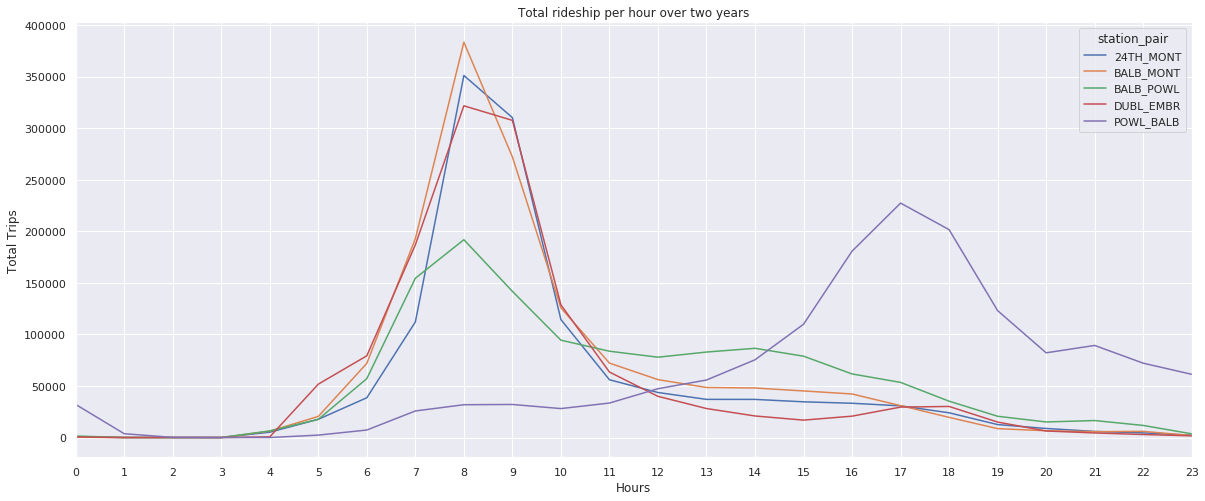

In [20]:
sns.set(rc={'figure.figsize':(20, 8)})

chart2 = df_avg_hourly.plot.line()
chart2.set_ylabel('Total Trips')
chart2.set_xlabel('Hours')
chart2.set_title('Total rideship per hour over two years')
chart2.xaxis.set_ticks(np.arange(0, 24, 1))

plt.show()

#scale the y axis

By plotting the total hours over two years by hourly blocks we can see there are common trends. BALB_MONT, 24TH_MONT, DUBL_EMBR and BALB_POWL all have increased trips between 6:00am and 10:00am and peak at 8:00am. POWL_BALB has increased trips between 3:00pm and 8:00pm with a peak at 5:00pm.

### Plotting the distribution of the trains travelled between disctricts (yearly rideship):

To create the data for the chart. First a lookup dictionary is created.

In [21]:
stations = df.org_station.unique()
districts = np.array(['D4','D9','D4','D9','D7',
                         'D8','D3','D5','D9','D4',
                         'D4','D1','D9','D3','D3',
                         'D5','D8','D6','D4','D9',
                         'D5','D1','D4','D7','D2',
                         'D7','D1','D1','D4','D1',
                         'D1','D2','D1','D9','D7',
                         'D3','D3','D0','D8','D6',
                         'D5','D6','D1','D5','D7',
                         'D6','D2','D2'])
district_lookup = {}
for x, y in zip(stations, districts):
    district_lookup[x] = y

In [23]:
df_districts_count = df[['org_station','dest_station','trip_count']]
df_districts_count['org_district'] = df_districts_count['org_station'].map(district_lookup)
df_districts_count['dest_district'] = df_districts_count['dest_station'].map(district_lookup)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [24]:
df_districts_count.head()

,org_station,dest_station,trip_count,org_district,dest_district
0,12TH,19TH,1,D4,D4
1,12TH,24TH,2,D4,D9
2,12TH,BAYF,1,D4,D3
3,12TH,CIVC,5,D4,D9
4,12TH,COLS,2,D4,D4


In [159]:
#df_districts = pd.read_excel('https://www.bart.gov/sites/default/files/docs/Station_Names.xls')
#df_districts.drop('Unnamed: 0',axis=1, inplace=True)
#df_districts.columns = ['two_code','station_name']
#get the two missing values
#df.org_station.unique()[46:]
# 4 letter Station Abbreviations https://api.bart.gov/docs/overview/abbrev.aspx
#listOfSeries = [pd.Series(['AN', 'Antioch'], index=df_districts.columns),
#                pd.Series(['PC', 'Pittsburg Center'], index=df_districts.columns)]
#df_districts = df_districts.append(listOfSeries , ignore_index=True)
#df_districts = df_districts.sort_values(['station_name'],ascending=True)
#df_districts['four_code'] = sorted(list(df.org_station.unique()))
#df_districts

Creating the Chord Diagram:

In [25]:
df_districts_count = df_districts_count.pivot_table(index = 'org_district', columns = 'dest_district', values= 'trip_count', aggfunc = np.sum, fill_value=0)
df_districts_count.head()

dest_district,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9
org_district,,,,,,,,,,
D0,12898,78396,55849,78012,168381,44131,14282,476839,454101,751971
D1,75013,1610405,647736,1592215,3093738,224179,238872,4765871,5652873,4533955
D2,61838,650926,159507,349240,858977,131228,73911,1638656,1663344,2413059
D3,77855,1576802,347778,2004080,3799730,873544,931795,3967323,3629795,4890040
D4,168997,3078935,832892,3931929,2772220,2047858,1748191,5259207,4861957,7449408


In [26]:
## need to group each place in a district and sum the counts
#df_districts_count = df[['org_station','dest_station','trip_count']]
#df_districts_count = df_districts_count.pivot_table(index = 'org_district', columns = 'dest_district', values= 'trip_count', aggfunc = np.sum, fill_value=0)
#df_districts_count.head()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
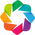

In [27]:
hv.extension('bokeh')
hv.output(size = 200)

In [28]:
chord_data = hv.Dataset((list(df_districts_count.columns), list(df_districts_count.index), df_districts_count),
                  ['source', 'target'], 'value').dframe()

In [29]:
chord = hv.Chord(chord_data)
chord.opts(
    node_color='index', edge_color='source', label_index='index', 
    cmap='Category10', edge_cmap='Category10', width=500, height=500)

:Chord   [source,target]   (value)

### Creating a demand prediction model:

Using the daily average trips over the course of two years we will attempt to predict the average usage based on the daily seasonality of the data.

In [49]:
df_daily_trips = df_avg_daily.drop(columns = 'day')

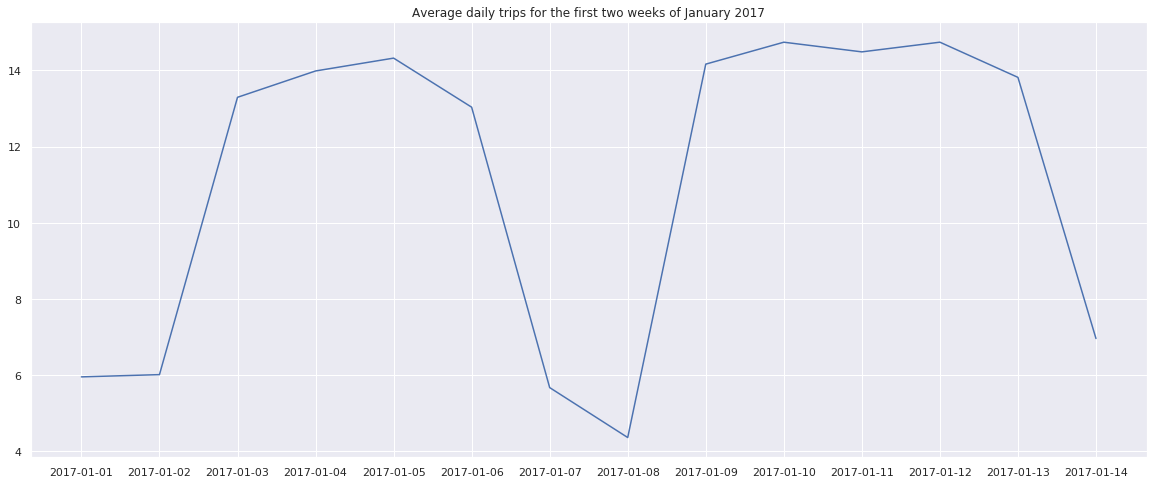

In [52]:
two_weeks = df_avg_daily.head(14)
plt.plot(two_weeks)
plt.title('Average daily trips for the first two weeks of January 2017')
plt.show()

The chart above shows the daily seasonality of the average trips. The peaks occur on weekdays, Monday to Friday with troughs occurring on weekends, Saturday and Sunday. One outlier from the trend is on a Monday '2017-01-02' which is a public holiday, New Years's Day.

The *df_avg_daily_opt* dataframe which we created earlier can be used in order to produce a new dataframe for building the model on.

In [68]:
df_weekly_avg = df_avg_daily_opt[['day','avg_trips']]
df_weekly_avg = df_weekly_avg.groupby(['day'],as_index=False).sum()

In [69]:
df_weekly_avg.head()

,day,avg_trips
0,Friday,1347.917404
1,Monday,1350.983554
2,Saturday,756.963271
3,Sunday,636.784347
4,Thursday,1456.814149
